# <i class="fa-solid fa-gear"></i> Support Vector Machines

After a brief excursion into generative models such as [LDA & QDA](5_LDA_QDA.md) or [Naïve Bayes](6_Naive_Bayes.md), we will now again discuss a discriminative family of models: Support Vector Machines (SVM). SVMs are powerful supervised learning models used for classification and regression tasks. When used for classification, they are called Support Vector Classifiers (SVC).

Let's consider some simulated classification data:

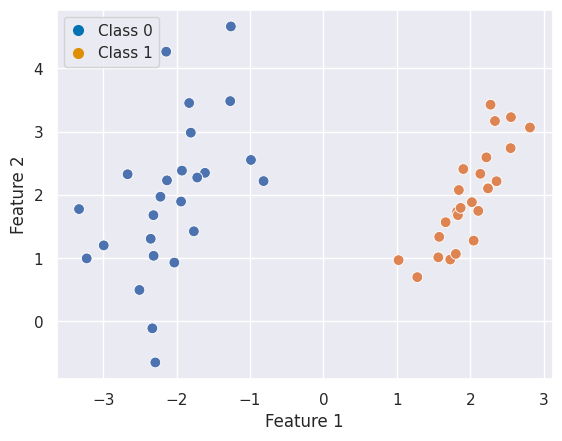

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.lines import Line2D
from sklearn.datasets import make_classification
sns.set_theme(style="darkgrid")

X, y = make_classification(n_samples=50, n_features=2, n_informative=2, n_redundant=0, 
                           n_clusters_per_class=1, class_sep=2.0, random_state=0)

fig, ax = plt.subplots()
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=60, ax=ax)
ax.set(xlabel="Feature 1", ylabel="Feature 2")

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None', markersize=8, label='Class 0', markerfacecolor="#0173B2", markeredgecolor='None'),
    Line2D([0], [0], marker='o', linestyle='None', markersize=8, label='Class 1', markerfacecolor="#DE8F05", markeredgecolor='None')]
ax.legend(handles=legend_elements, loc="upper left", handlelength=1);

In [2]:
from jupyterquiz import display_quiz
display_quiz("quiz/SVC.json", shuffle_answers=True)

<IPython.core.display.Javascript object>

```{admonition} Solution
:class: dropdown

There are infinite ways to separate the two classes because you can find an infinte amount of lines which perfectly separate them.
```

If we visualise this and add a new data point for classification a potential issue becomes apparent. For some models, this data point would fall into Class 0 and for others into Class 1:

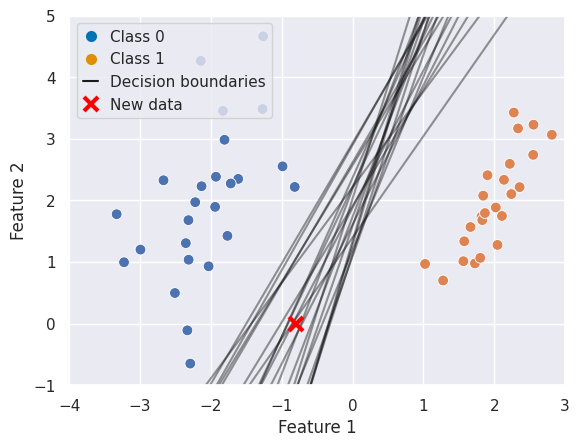

In [3]:
from collections import OrderedDict

fig, ax = plt.subplots()
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=ax, s=60)

x_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
np.random.seed(42)
slopes = np.random.uniform(1.5, 4, 20)
intercepts = np.random.uniform(1, 3, 20)

for i, (m, b) in enumerate(zip(slopes, intercepts)):
    alpha = 0.4
    ax.plot(x_vals, m * x_vals + b, color='black', alpha=alpha, label='Decision boundaries' if i == 0 else None)

ax.plot(-0.8, 0, 'x', color='red', markeredgewidth=3, markersize=10, label="New data")

ax.set_xlim(-4, 3)
ax.set_ylim(-1, 5)
ax.set(xlabel="Feature 1", ylabel="Feature 2")

# Custom egend
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None', markersize=8, label='Class 0', markerfacecolor="#0173B2", markeredgecolor='None'),
    Line2D([0], [0], marker='o', linestyle='None', markersize=8, label='Class 1', markerfacecolor="#DE8F05", markeredgecolor='None'),
    Line2D([0], [0], color='k', linestyle='-', label='Decision boundaries'),
    Line2D([0], [0], marker='x', color='red', markersize=10, markeredgewidth=3, label='New data', markerfacecolor='None', linestyle='None')]
ax.legend(handles=legend_elements, loc="upper left", handlelength=1);

## Support Vector Classifiers (SVC)

So evidently, we can't just be satisfied with having an infinite amount of possible solutions we need to come up with a more justifiable one. If you remember, we already did so for linear regression: there, the least squares method chose the line that minimised the total squared distance between predictions and true values.

Support Vector Classifiers have a slightly different method. As Robert Tibshirani put it, they are

> An approach to the classification problem in a way computer scientists would approach it.

Rather than minimising a squared error, they aim to find the hyperplane that maximises the margin — the distance between the separating hyperplane and the closest data points from each class. The idea is that by maximising this margin, we obtain a decision boundary that is both robust and generalisable.

- **Hyperplane**: A decision boundary that separates classes. In p dimensions, it is a p−1 dimensional subspace, given by the equation: $\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p = 0$. So in the case of two predictors the hyperplane is one dimensional (a line).
- **Separating Hyperplane**: A hyperplane that correctly separates the data by class label.
- **Margin**: The (perpendicular) distance between the hyperplane and the closest training points. A maximal margin classifier chooses the hyperplane that maximises this margin.
- **Support Vectors**: Observations closest to the decision boundary. They define the margin and the classifier.
- **Soft Margin**: A method used when the data is not linearly separable. Allows some observations to violate the margin. Controlled via the hyperparameter $C$.
- **Kernel Trick**: Implicitly maps data into a higher-dimensional space to make it linearly separable using functions like polynomial or RBF (Gaussian) kernels.


To formalise this intuition, SVCs look for the maximum margin classifier — a hyperplane that not only separates the classes but does so with the greatest possible distance to the closest training samples. These closest samples are known as support vectors, and they uniquely determine the position of the hyperplane. All other samples can be moved without changing the decision boundary, making SVCs especially robust to outliers away from the margin.


## Using SVCs

As you learned in the lecture, SVCs are considered to be one of the best "out of the box" classifiers and can be used in many scenarios. This includes:

- When the number of features is large relative to the number of samples
- When classes are not linearly separable
- When a robust and generalisable classifier is needed

If the data is not perfectly separable (either because the classes overlap, or the classes are not linearly separable) SVCs become creative in two ways

1. "Soften" what is meant by separating the classes and allow for errors
2. Map feature space into a higher dimension (kernel trick)


### Example 1: Linear Classification

Fitting a SVC is straigthforward:

In [4]:
from sklearn.svm import SVC

clf = SVC(kernel='linear')
clf.fit(X, y);

With a little helper function we can visualize the decision function and supports:

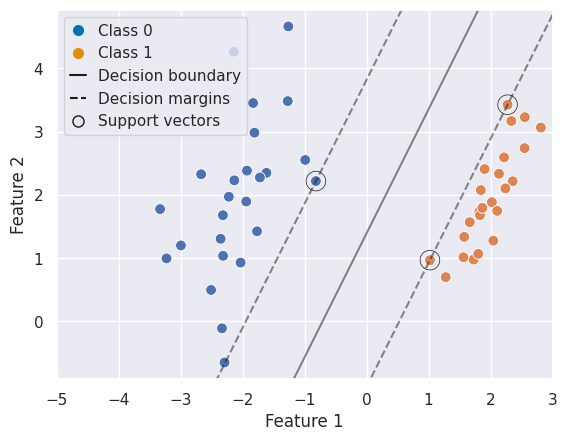

In [5]:
def plot_svc_decision_function(model, ax=None):
    """Plot the decision boundary and margins for a trained 2D SVC model."""
    # Set up grid
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(*xlim, 100), np.linspace(*ylim, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]
    decision_values = model.decision_function(grid).reshape(xx.shape)

    # Plot decision boundary and margins
    ax.contour(xx, yy, decision_values, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k', alpha=0.5)

    # Support vectors
    ax.scatter(*model.support_vectors_.T, s=200, linewidth=0.5, facecolors='none', edgecolors='k')

fig, ax = plt.subplots()
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=60, ax=ax)
ax.set(xlabel="Feature 1", ylabel="Feature 2", xlim=(-5,3))
plot_svc_decision_function(clf, ax=ax)

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None', markersize=8, label='Class 0', markerfacecolor="#0173B2", markeredgecolor='None'),
    Line2D([0], [0], marker='o', linestyle='None', markersize=8, label='Class 1', markerfacecolor="#DE8F05", markeredgecolor='None'),
    Line2D([0], [0], color='k', linestyle='-', label='Decision boundary'),
    Line2D([0], [0], color='k', linestyle='--', label='Decision margins'),
    Line2D([0], [0], marker='o', color='k', markersize=8, label='Support vectors', markerfacecolor='None', linestyle='None')]
ax.legend(handles=legend_elements, loc="upper left", handlelength=1);

### Example 2: Nonlinear Classification

Let's consider different data, which is not linearly separable:

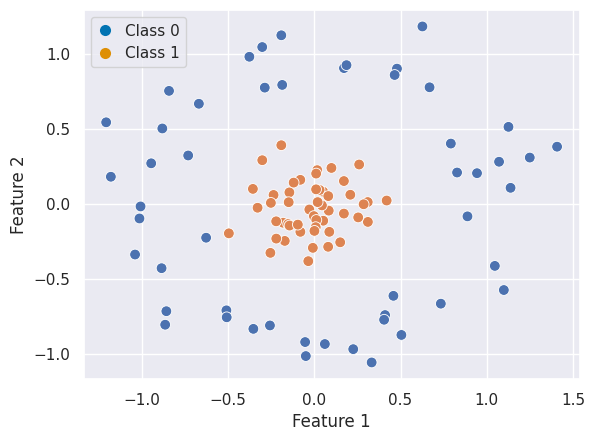

In [6]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.15)

fig, ax = plt.subplots()
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=60, ax=ax)
ax.set(xlabel="Feature 1", ylabel="Feature 2")

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None', markersize=8, label='Class 0', markerfacecolor="#0173B2", markeredgecolor='None'),
    Line2D([0], [0], marker='o', linestyle='None', markersize=8, label='Class 1', markerfacecolor="#DE8F05", markeredgecolor='None')]
ax.legend(handles=legend_elements, loc="upper left", handlelength=1);

In that case, non-linear SVC can be applied. For example, a simple projection would be a radial basis function centered on the middle clump. As you can see, the data becomes linearly separable in three dimensions:

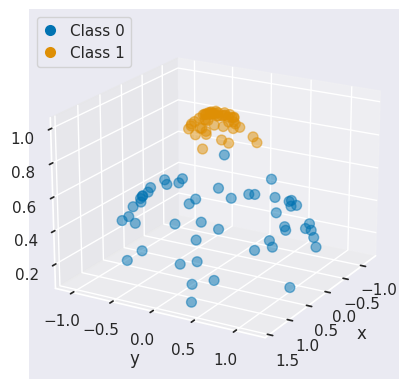

In [7]:
from mpl_toolkits import mplot3d

# Apply radial basis function to the feature space
r = np.exp(-(X ** 2).sum(1))

# Plot features in 3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colors = np.array(["#0173B2", "#DE8F05"])[y] # colors for each class
ax.scatter(X[:, 0], X[:, 1], r, c=colors, s=50, alpha=0.5, edgecolors=colors)
ax.view_init(elev=20, azim=30)
ax.set(xlabel='x', ylabel='y', zlabel='r');

# Custom egend
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None', markersize=8, label='Class 0', markerfacecolor="#0173B2", markeredgecolor='None'),
    Line2D([0], [0], marker='o', linestyle='None', markersize=8, label='Class 1', markerfacecolor="#DE8F05", markeredgecolor='None')]
ax.legend(handles=legend_elements, loc="upper left", handlelength=1);

We can create a similar plot as above, first with a linear SVC and second with a RBF SVC to visualize the decision boundary, margins, and support vectors:

Linear SVC classification report:
               precision    recall  f1-score   support

           0       0.83      0.33      0.48        15
           1       0.58      0.93      0.72        15

    accuracy                           0.63        30
   macro avg       0.71      0.63      0.60        30
weighted avg       0.71      0.63      0.60        30



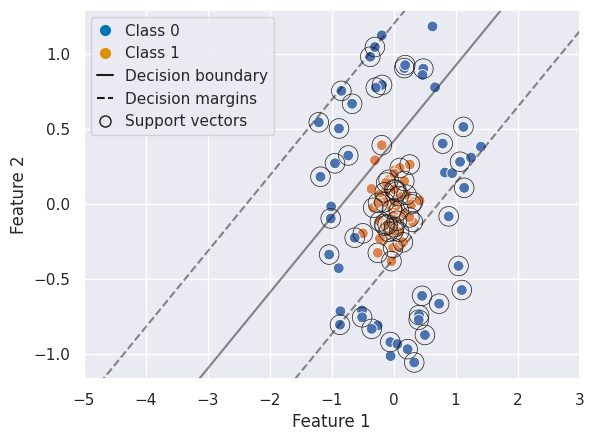

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Linear SVC
clf_lin = SVC(kernel='linear')
clf_lin.fit(X_train, y_train)

y_pred = clf_lin.predict(X_test) 
print("Linear SVC classification report:\n", classification_report(y_test, y_pred))

# Plot
fig, ax = plt.subplots()
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=60, ax=ax)
ax.set(xlabel="Feature 1", ylabel="Feature 2", xlim=(-5,3))
plot_svc_decision_function(clf_lin, ax=ax)

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None', markersize=8, label='Class 0', markerfacecolor="#0173B2", markeredgecolor='None'),
    Line2D([0], [0], marker='o', linestyle='None', markersize=8, label='Class 1', markerfacecolor="#DE8F05", markeredgecolor='None'),
    Line2D([0], [0], color='k', linestyle='-', label='Decision boundary'),
    Line2D([0], [0], color='k', linestyle='--', label='Decision margins'),
    Line2D([0], [0], marker='o', color='k', markersize=8, label='Support vectors', markerfacecolor='None', linestyle='None')]
ax.legend(handles=legend_elements, loc="upper left", handlelength=1);

RBF SVC classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



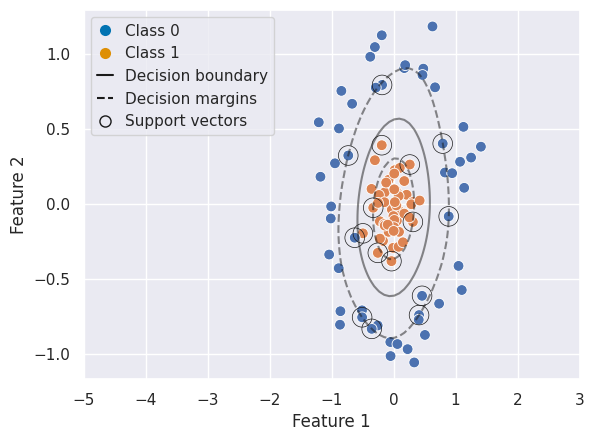

In [9]:
# RBF SVC
clf_rbf = SVC(kernel='rbf')
clf_rbf.fit(X_train, y_train)

y_pred = clf_rbf.predict(X_test) 
print("RBF SVC classification report:\n", classification_report(y_test, y_pred))

# Plot
fig, ax = plt.subplots()
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, s=60, ax=ax)
ax.set(xlabel="Feature 1", ylabel="Feature 2", xlim=(-5,3))
plot_svc_decision_function(clf_rbf, ax=ax)

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None', markersize=8, label='Class 0', markerfacecolor="#0173B2", markeredgecolor='None'),
    Line2D([0], [0], marker='o', linestyle='None', markersize=8, label='Class 1', markerfacecolor="#DE8F05", markeredgecolor='None'),
    Line2D([0], [0], color='k', linestyle='-', label='Decision boundary'),
    Line2D([0], [0], color='k', linestyle='--', label='Decision margins'),
    Line2D([0], [0], marker='o', color='k', markersize=8, label='Support vectors', markerfacecolor='None', linestyle='None')]
ax.legend(handles=legend_elements, loc="upper left", handlelength=1);

## Multiclass Classification

SVCs are inherently binary classifiers but can be extended:

* **One-vs-One**: $\binom{K}{2}$ classifiers for each pair of classes.
* **One-vs-All**: K classifiers, each comparing one class against the rest.

In `sklearn` you can, for example, use the `ovo` decision function for one-vs-one classification:

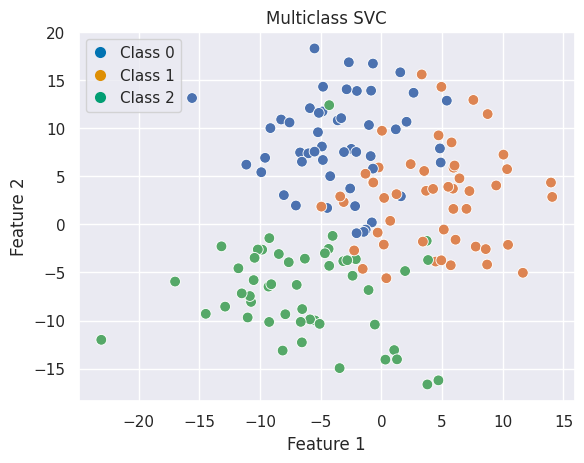

Multiclass classification report:
               precision    recall  f1-score   support

           0       0.78      0.58      0.67        12
           1       0.65      0.85      0.73        13
           2       1.00      0.92      0.96        13

    accuracy                           0.79        38
   macro avg       0.81      0.78      0.79        38
weighted avg       0.81      0.79      0.79        38



In [10]:
from sklearn.datasets import make_blobs

# Generate data
X, y = make_blobs(n_samples=150, centers=3, random_state=42, cluster_std=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Plot
fig, ax = plt.subplots()
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='deep', ax=ax, s=60)
ax.set(xlabel="Feature 1", ylabel="Feature 2", title="Multiclass SVC")

legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None', markersize=8, label='Class 0', markerfacecolor="#0173B2", markeredgecolor='None'),
    Line2D([0], [0], marker='o', linestyle='None', markersize=8, label='Class 1', markerfacecolor="#DE8F05", markeredgecolor='None'),
    Line2D([0], [0], marker='o', linestyle='None', markersize=8, label='Class 2', markerfacecolor="#029E73", markeredgecolor='None')]
ax.legend(handles=legend_elements, loc="upper left", handlelength=1);
plt.show()

# Multiclass prediciton
clf = SVC(kernel='rbf', decision_function_shape='ovo')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Multiclass classification report:\n", classification_report(y_test, y_pred))

## Choosing Hyperparameters

SVCs have a few hyperparameters. Please have a look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) for a more in-depth overview. For the SVC used in the previous examples, the most important ones are:

* `C`: Regularisation parameter; trade-off between margin width and classification error.
* `kernel`: `'linear'`, `'poly'`, `'rbf'`, `'sigmoid'`, or custom.
* `gamma`: Kernel coefficient (for RBF, polynomial, and sigmoid kernels)

```{admonition} Note
:class: warning 

In `sklearn` (and usually also MATLAB and R) `C` behaves inversely to what you were shown in the lecture. Small values of C will result in a wider margin, at the cost of misclassifications (high bias, low variance). Large values of C will give you a smaller margin and fit the training data more tightly (low bias, higher variance).
```

As always, hyperparameters should be tuned using [cross-validation](../1_basics/3_resampling.md) to balance bias and variance. It often makes sense to use a [grid search](https://scikit-learn.org/stable/modules/grid_search.html) or related strategies to find the optimal solution:

Best parameters: {'C': np.float64(385.6620421163472), 'gamma': np.float64(0.7880462815669912), 'kernel': 'rbf'}
Best cross-validation score: 0.8666666666666668
Test set score: 0.88


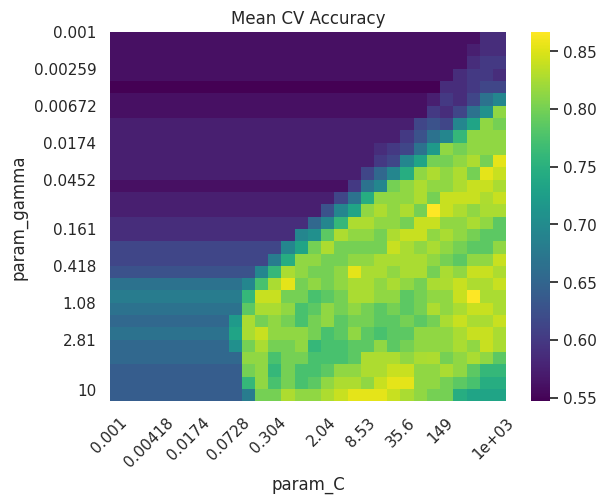

In [11]:
import pandas as pd
from sklearn.model_selection import GridSearchCV

# Generate data
X, y = make_circles(100, factor=.1, noise=.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

# Grid search
C_vals = np.logspace(-3, 3, 30)     # 0.001 to 1000
gamma_vals = np.logspace(-3, 1, 30) # 0.001 to 10
param_grid = {'C': C_vals, 'kernel': ['rbf'], 'gamma': gamma_vals}

grid = GridSearchCV(SVC(), param_grid, cv=5)
grid.fit(X_train, y_train)

# Results
print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)
print("Test set score:", grid.score(X_test, y_test))

# Plot heatmap
results = pd.DataFrame(grid.cv_results_)
scores_matrix = results.pivot(index='param_gamma', columns='param_C', values='mean_test_score') # Pivot table to make a matrix of mean test scores

fig, ax = plt.subplots()
sns.heatmap(
    scores_matrix,
    cmap="viridis",
    xticklabels=False,
    yticklabels=False,
    ax=ax)

# Plot custom ticks
n_ticks = 10 # plot n ticks
xticks = np.linspace(0, len(scores_matrix.columns) - 1, n_ticks, dtype=int)
yticks = np.linspace(0, len(scores_matrix.index) - 1, n_ticks, dtype=int)

xticklabels = [f"{scores_matrix.columns[i]:.3g}" for i in xticks]
yticklabels = [f"{scores_matrix.index[i]:.3g}" for i in yticks]

ax.set(xticks=xticks, yticks=yticks, yticklabels=yticklabels, title="Mean CV Accuracy")
ax.set_xticklabels(xticklabels, rotation=45);

```{admonition} Summary
:class: note 

- Support Vector Classifiers are a robust and versatile tool for classification tasks
- The key ideas are rooted in geometry - finding the optimal hyperplane that separates data with maximum margin
- With the use of kernels, SVCs extend effectively to non-linear decision boundaries
- Multiclass classification can be done in a one-vs-one or one-vs-all approach
- Even though we did not do so here, it is often useful to scale the predictors (see exercise)
```

## Additional References

For more information and a cool example for facial recognition, you can have look at the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html) notebook.